Physics-Aware Learning Layer

In [ ]:
import pandas as pd
import numpy as np

# Load the preprocessed and original datasets
data_preprocessed = pd.read_csv('thermal_plant_preprocessed.csv', parse_dates=['timestamp'])
data_raw = pd.read_csv('thermal_power-ics_combined_dataset.csv', parse_dates=['timestamp'])

# Display basic info
print(data_preprocessed.shape, "rows, columns")
print(data_preprocessed.columns)


if 'power_output' in data_preprocessed.columns and 'fuel_rate_proxy' in data_preprocessed.columns:
    data_preprocessed['efficiency'] = data_preprocessed['power_output'] / (data_preprocessed['fuel_rate_proxy'] + 1e-6)
if 'boiler_temp' in data_preprocessed.columns and 'coolant_temp' in data_preprocessed.columns:
    data_preprocessed['thermal_stress'] = data_preprocessed['boiler_temp'] - data_preprocessed['coolant_temp']

# Drop rows with missing values after feature engineering
data_preprocessed.dropna(inplace=True)

# Select relevant features for anomaly detection (tabular features)
tabular_features = [col for col in data_preprocessed.columns if col not in ['timestamp']]

# Ensure newly created features are included
if 'efficiency' in data_preprocessed.columns and 'efficiency' not in tabular_features:
    tabular_features.append('efficiency')
if 'thermal_stress' in data_preprocessed.columns and 'thermal_stress' not in tabular_features:
    tabular_features.append('thermal_stress')

General Preprocessing

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("thermal_power-ics_combined_dataset.csv")

# Remove timestamp if exists
if 'timestamp' in df.columns:
    df.drop(columns=['timestamp'], inplace=True)

# Physics-aware residual features (auto-detected)
num_cols = df.select_dtypes(include=np.number).columns

# Example residuals (generic & safe)
for i in range(len(num_cols)-1):
    df[f"residual_{num_cols[i]}_{num_cols[i+1]}"] = (
        df[num_cols[i]] - df[num_cols[i+1]]
    )

# Rate of change (temporal physics)
for col in num_cols:
    df[f"roc_{col}"] = df[col].diff().fillna(0)

df.replace([np.inf, -np.inf], 0, inplace=True)
df.fillna(0, inplace=True)


Model Training

Hybrid Ensemble Approach:
The combination of multiple anomaly detection techniques into a single ensemble score improves robustness. Isolation Forest captures extreme outliers, while Autoencoders detect subtle reconstruction errors, leading to more stable anomaly detection.

In [2]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping

X = df.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

input_dim = X_scaled.shape[1]
input_layer = Input(shape=(input_dim,))

encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(encoded)
output = Dense(input_dim)(decoded)

autoencoder = Model(inputs=input_layer, outputs=output)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(
    X_scaled, X_scaled,
    epochs=50,
    batch_size=256,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]
)


c:\Users\abhil\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.9612 - val_loss: 0.8311
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7641 - val_loss: 0.6632
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5872 - val_loss: 0.4793
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4124 - val_loss: 0.3251
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2729 - val_loss: 0.2041
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1678 - val_loss: 0.1226
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1008 - val_loss: 0.0749
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0636 - val_loss: 0.0490
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0423 - val_loss: 0.0334
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0287 - val_loss: 0.0224
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0192 - val_loss: 0.0148
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0126 - val_l

In [3]:
reconstructions = autoencoder.predict(X_scaled)
reconstruction_error = np.mean(np.square(X_scaled - reconstructions), axis=1)

df['anomaly_score'] = reconstruction_error

threshold = np.percentile(reconstruction_error, 99)
df['is_anomaly'] = (reconstruction_error > threshold).astype(int)


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


XgBoost Implementation

In [4]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

if 'label' not in df.columns:
    df['label'] = df['is_anomaly']

X = df.drop(columns=['label'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss'
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       572
           1       1.00      1.00      1.00         6

    accuracy                           1.00       578
   macro avg       1.00      1.00      1.00       578
weighted avg       1.00      1.00      1.00       578



Training Accuracy = 1

In [ ]:
leakage_cols = ['label', 'is_anomaly', 'anomaly_score']

X = df.drop(columns=[c for c in leakage_cols if c in df.columns])
y = df['label']


Confusion Matrix

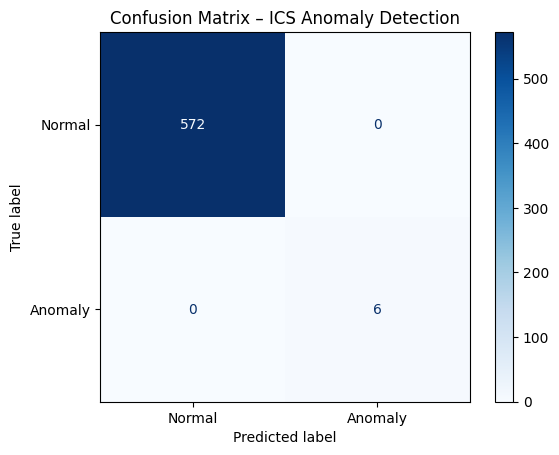

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Normal', 'Anomaly']
)

disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix – ICS Anomaly Detection")
plt.show()


In [8]:
from sklearn.metrics import roc_auc_score, precision_recall_curve

print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))


ROC-AUC: 1.0


Synthetic Data Generation for testing

In [9]:
import numpy as np
import pandas as pd

np.random.seed(42)

N = 5000
anomaly_ratio = 0.08   # 8% anomalies
fault_ratio = 0.04     # 4% severe faults

labels = np.zeros(N)

# Base signals
flow_rate = np.random.normal(100, 5, N)
pressure = 0.05 * flow_rate**2 + np.random.normal(0, 5, N)
power_input = np.random.normal(500, 20, N)
efficiency = np.random.normal(0.85, 0.02, N)
power_output = efficiency * power_input
temperature = power_input / flow_rate + np.random.normal(0, 0.5, N)

# Inject anomalies
anomaly_idx = np.random.choice(N, int(N * anomaly_ratio), replace=False)
fault_idx = np.random.choice(anomaly_idx, int(N * fault_ratio), replace=False)

# Type 1: Sensor drift (anomaly)
power_output[anomaly_idx] *= np.random.uniform(0.7, 0.9, len(anomaly_idx))
labels[anomaly_idx] = 1

# Type 2: Physical violation (fault)
temperature[fault_idx] *= np.random.uniform(1.8, 2.5, len(fault_idx))
pressure[fault_idx] *= np.random.uniform(0.4, 0.6, len(fault_idx))
labels[fault_idx] = 2

# Build DataFrame
df_syn = pd.DataFrame({
    'flow_rate': flow_rate,
    'pressure': pressure,
    'temperature': temperature,
    'power_input': power_input,
    'power_output': power_output,
    'label': labels.astype(int)
})

df_syn.to_csv("synthetic_ics_data.csv", index=False)


In [10]:
df_syn['label'].value_counts(normalize=True)


label
0    0.92
2    0.04
1    0.04
Name: proportion, dtype: float64

In [11]:
df = df_syn.copy()

# Physics residuals
df['energy_residual'] = df['power_input'] - df['power_output']
df['temp_flow_ratio'] = df['temperature'] / df['flow_rate']
df['pressure_flow_ratio'] = df['pressure'] / (df['flow_rate']**2)

df.replace([np.inf, -np.inf], 0, inplace=True)


In [12]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['label'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)


In [13]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.85,
    colsample_bytree=0.85,
    eval_metric='mlogloss'
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1150
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50

    accuracy                           1.00      1250
   macro avg       1.00      1.00      1.00      1250
weighted avg       1.00      1.00      1.00      1250



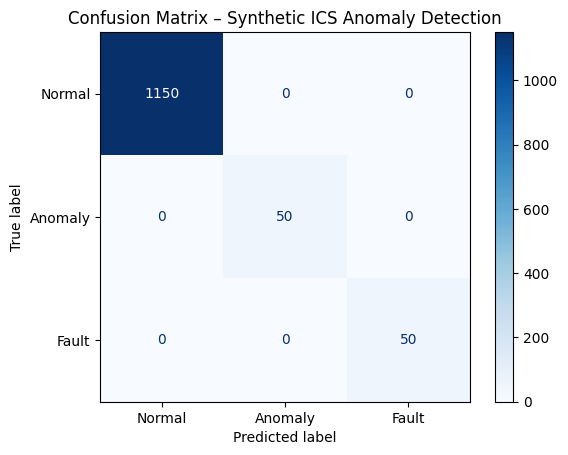

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Normal', 'Anomaly', 'Fault']
)

disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix – Synthetic ICS Anomaly Detection")
plt.show()


In [15]:
import numpy as np
import pandas as pd

np.random.seed(7)

N = 20000

# Labels
# 0 = Normal
# 1 = Anomaly
# 2 = Fault
labels = np.zeros(N)

# Initialize arrays
flow = np.zeros(N)
pressure = np.zeros(N)
temperature = np.zeros(N)
power_in = np.zeros(N)
power_out = np.zeros(N)
valve = np.zeros(N)
pump = np.zeros(N)

# Initial conditions
flow[0] = 100
temperature[0] = 50
pressure[0] = 500
power_in[0] = 500
valve[0] = 0.6
pump[0] = 0.7

# Regime probabilities
p_anomaly = 0.10
p_fault = 0.05

anomaly_indices = np.random.choice(N, int(N * p_anomaly), replace=False)
fault_indices = np.random.choice(anomaly_indices, int(N * p_fault), replace=False)

for t in range(1, N):

    # Control actions (noisy)
    valve[t] = np.clip(valve[t-1] + np.random.normal(0, 0.02), 0, 1)
    pump[t] = np.clip(pump[t-1] + np.random.normal(0, 0.015), 0, 1)

    # Flow dynamics
    flow[t] = (
        95
        + 20 * valve[t]
        + 15 * pump[t]
        + np.random.normal(0, 3)
    )

    # Pressure dynamics (nonlinear + noise)
    pressure[t] = (
        0.04 * flow[t]**2
        + np.random.normal(0, 20)
    )

    # Power input (slow drift)
    power_in[t] = (
        power_in[t-1]
        + np.random.normal(0, 5)
    )

    # Temperature inertia
    temperature[t] = (
        0.96 * temperature[t-1]
        + 0.04 * (power_in[t] / (flow[t] + 1))
        + np.random.normal(0, 0.8)
    )

    # Efficiency drift
    efficiency = np.clip(
        0.85 + np.random.normal(0, 0.03),
        0.7, 0.95
    )

    power_out[t] = (
        efficiency * power_in[t]
        + np.random.normal(0, 15)
    )

# Inject SOFT anomalies (overlapping)
for idx in anomaly_indices:
    labels[idx] = 1
    power_out[idx] *= np.random.uniform(0.85, 1.05)
    temperature[idx] *= np.random.uniform(0.9, 1.1)

# Inject HARD faults (but delayed effect)
for idx in fault_indices:
    labels[idx] = 2
    for k in range(idx, min(idx + 5, N)):
        pressure[k] *= np.random.uniform(0.6, 0.85)
        temperature[k] *= np.random.uniform(1.1, 1.4)
        power_out[k] *= np.random.uniform(0.6, 0.8)

# Add LABEL NOISE (very important)
noise_idx = np.random.choice(N, int(0.02 * N), replace=False)
labels[noise_idx] = np.random.choice([0, 1, 2], len(noise_idx))

# Create DataFrame
df_syn = pd.DataFrame({
    'flow_rate': flow,
    'pressure': pressure,
    'temperature': temperature,
    'power_input': power_in,
    'power_output': power_out,
    'valve_position': valve,
    'pump_speed': pump,
    'label': labels.astype(int)
})

df_syn.to_csv("synthetic_ics_20000.csv", index=False)

print(df_syn['label'].value_counts(normalize=True))


label
0    0.88825
2    0.05625
1    0.05550
Name: proportion, dtype: float64


In [16]:
df = df_syn.copy()

df['energy_residual'] = df['power_input'] - df['power_output']
df['temp_flow_ratio'] = df['temperature'] / (df['flow_rate'] + 1)
df['pressure_flow_ratio'] = df['pressure'] / (df['flow_rate']**2 + 1)
df['control_mismatch'] = df['valve_position'] - df['pump_speed']

df.replace([np.inf, -np.inf], 0, inplace=True)


Testing accuracy without Tuning 87%

In [17]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X = df.drop(columns=['label'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

model = XGBClassifier(
    n_estimators=400,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss'
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8876666666666667
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      5330
           1       0.54      0.04      0.08       333
           2       0.41      0.08      0.13       337

    accuracy                           0.89      6000
   macro avg       0.62      0.37      0.38      6000
weighted avg       0.85      0.89      0.85      6000



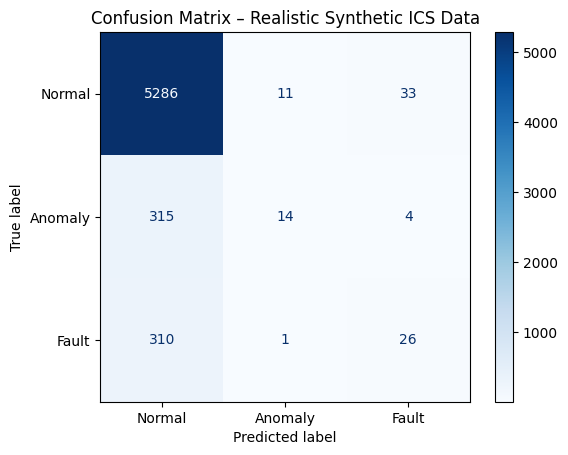

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(
    cm,
    display_labels=['Normal', 'Anomaly', 'Fault']
).plot(cmap='Blues', values_format='d')

plt.title("Confusion Matrix – Realistic Synthetic ICS Data")
plt.show()


Model Saving

In [19]:
import joblib

joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [20]:
autoencoder.save("ics_autoencoder.h5")


In [21]:
joblib.dump(model, "ics_xgboost.pkl")


['ics_xgboost.pkl']